<a href="https://colab.research.google.com/github/valenderval/MLA_JFV/blob/main/MLA5_JFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Assignment 5
Jacob Vallery <br>CS430-ON <br>Machine Learning in the Cloud

#Standard Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Imports for specific models

In [34]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#Imports for Splitting Data and Building Pipeline

In [35]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#Imports for Performance Measures

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

#Confusion Matrix Function

In [37]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

#ROC_Curve Function

In [38]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

#Problem 1

#Acquire Data

In [39]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/banknote_authentication.csv')

In [40]:
landsat_train = pd.read_csv('/content/gdrive/MyDrive/CS430/landsat_train.csv')

In [41]:
landsat_test = pd.read_csv('/content/gdrive/MyDrive/CS430/landsat_test.csv')

#Statistics and Visual Exploration

In [42]:
land_types_train = landsat_train['land_type'].value_counts()

In [43]:
land_types_test = landsat_test['land_type'].value_counts()

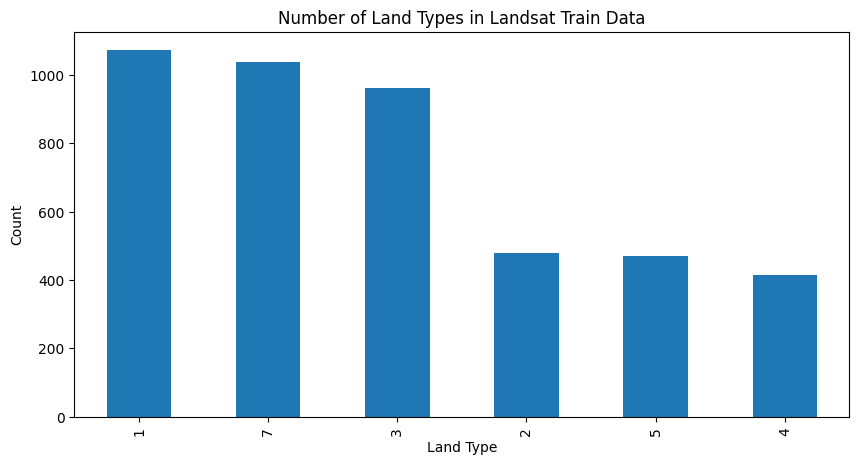

In [45]:
plt.figure(figsize=(10, 5))
land_types_train.plot(kind='bar')
plt.title('Number of Land Types in Landsat Train Data')
plt.xlabel('Land Type')
plt.ylabel('Count')
plt.show()

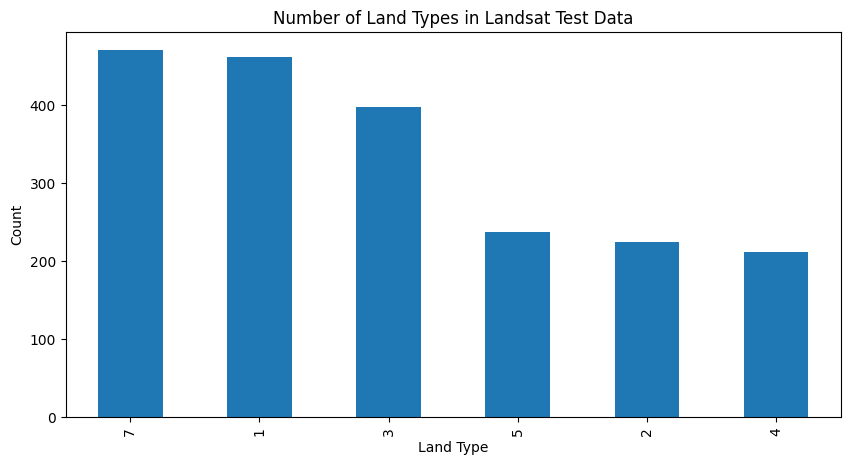

In [47]:
plt.figure(figsize=(10, 5))
land_types_test.plot(kind='bar')
plt.title('Number of Land Types in Landsat Test Data')
plt.xlabel('Land Type')
plt.ylabel('Count')
plt.show()


#Splitting Data into Train/Test
 - the data is already split into train/test, but you will have to manually split it further.

In [48]:
landsat_train.head(2)

,top_left_r,top_left_g,top_left_infra1,top_left_infra2,top_middle_r,top_middle_g,top_middle_infra1,top_middle_infra2,top_right_r,top_right_g,...,bottom_left_infra2,bottom_middle_r,bottom_middle_g,bottom_middle_infra1,bottom_middle_infra2,bottom_right_r,bottom_right_g,bottom_right_infra1,bottom_right_infra2,land_type
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3


In [49]:
X_train = landsat_train.iloc[:,0:-1]
X_train.head(2)

,top_left_r,top_left_g,top_left_infra1,top_left_infra2,top_middle_r,top_middle_g,top_middle_infra1,top_middle_infra2,top_right_r,top_right_g,...,bottom_left_infra1,bottom_left_infra2,bottom_middle_r,bottom_middle_g,bottom_middle_infra1,bottom_middle_infra2,bottom_right_r,bottom_right_g,bottom_right_infra1,bottom_right_infra2
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79


In [50]:
X_test = landsat_test.iloc[:,0:-1]
X_test.head(2)

,top_left_r,top_left_g,top_left_infra1,top_left_infra2,top_middle_r,top_middle_g,top_middle_infra1,top_middle_infra2,top_right_r,top_right_g,...,bottom_left_infra1,bottom_left_infra2,bottom_middle_r,bottom_middle_g,bottom_middle_infra1,bottom_middle_infra2,bottom_right_r,bottom_right_g,bottom_right_infra1,bottom_right_infra2
0,80,102,102,79,76,102,102,79,76,102,...,109,87,79,107,109,87,79,107,113,87
1,76,102,102,79,76,102,106,83,76,102,...,109,87,79,107,113,87,79,103,104,83


In [51]:
y_train = landsat_train['land_type']
y_train.head(2)

,land_type
0,3
1,3


In [52]:
y_test = landsat_test['land_type']
y_test.head(2)

,land_type
0,3
1,3


#Building the Pipeline

In [53]:
num_attribs = landsat_train.columns[0:-1]
col_transform = ColumnTransformer(transformers=[
                               ('num',MinMaxScaler(), num_attribs),])

In [54]:
random_forest = Pipeline([
                           ('transform', col_transform),
                           ('rf',RandomForestClassifier(n_estimators=1000, max_samples=100, bootstrap=True))
                     ])

#Executing the Model

In [55]:
random_forest.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['top_left_r', 'top_left_g', 'top_left_infra1', 'top_left_infra2',
       'top_middle_r', 'top_middle_g', 'top_middle_infra1',
       'top_middle_infra2', 'top_right_r', 'top_right_g', 'top_right_infra1',
       'top_right_infra2', 'middle_left_r', 'middle_left_g',
       'middle_left_infra1', 'middle_l...
       'middle_right_r', 'middle_right_g', 'middle_right_infra1',
       'middle_right_infra2', 'bottom_left_r', 'bottom_left_g',
       'bottom_left_infra1', 'bottom_left_infra2', 'bottom_middle_r',
       'bottom_middle_g', 'bottom_middle_infra1', 'bottom_middle_infra2',
       'bottom_right_r', 'bottom_right_g', 'bottom_right_infra1',
       'bottom_right_infra2'],
      dtype='object'))])),
                ('rf',
                 RandomForestClassifier(max_samples=100, n_estimators=1000))])

#Evaluating the Model

In [56]:
y_pred = random_forest.predict(X_test)

In [57]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.98      0.89      0.93       506
           2       0.92      0.99      0.95       209
           3       0.96      0.86      0.91       444
           4       0.51      0.64      0.57       169
           5       0.68      0.89      0.77       181
           7       0.84      0.81      0.83       491

    accuracy                           0.85      2000
   macro avg       0.82      0.85      0.83      2000
weighted avg       0.87      0.85      0.86      2000



In [58]:
classes = random_forest.named_steps.rf.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

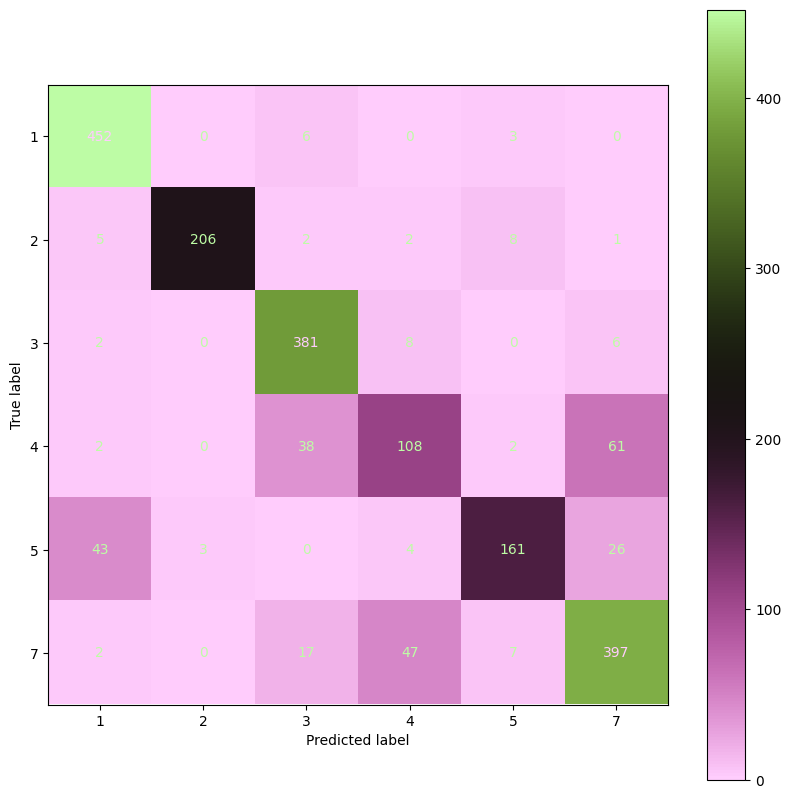

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap='vanimo')

#Conclusion

 A precision score of 87, a recall score of 86, and an F1 score of 86 indicate fairly accurate and consistent prdictions across metrics. This Random Forest model is doing a good job of distinguishing the positive class and has good balance between catching positives and avoiding false alarms. Though this model is doing well, another model may be better for predicting land type.

#Problem 2

#Bagging Calculator

#Building the Pipeline

In [60]:
bagging = Pipeline([
                     ('transform', col_transform),
                     ('bagging',BaggingClassifier(DecisionTreeClassifier(),n_estimators=1000, max_samples=len(X_train), bootstrap=True, n_jobs=-1))
                     ])

#Executing the Model

In [61]:
bagging.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['top_left_r', 'top_left_g', 'top_left_infra1', 'top_left_infra2',
       'top_middle_r', 'top_middle_g', 'top_middle_infra1',
       'top_middle_infra2', 'top_right_r', 'top_right_g', 'top_right_infra1',
       'top_right_infra2', 'middle_left_r', 'middle_left_g',
       'middle_left_infra1', 'middle_l...
       'middle_right_infra2', 'bottom_left_r', 'bottom_left_g',
       'bottom_left_infra1', 'bottom_left_infra2', 'bottom_middle_r',
       'bottom_middle_g', 'bottom_middle_infra1', 'bottom_middle_infra2',
       'bottom_right_r', 'bottom_right_g', 'bottom_right_infra1',
       'bottom_right_infra2'],
      dtype='object'))])),
                ('bagging',
                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                   max_samples=4435, n_estimators=1000,
                                   n_jobs=-1))])

#Evaluating the Model

In [62]:
y_pred = bagging.predict(X_test)

In [63]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       467
           2       0.98      0.98      0.98       224
           3       0.94      0.87      0.90       427
           4       0.63      0.73      0.67       181
           5       0.87      0.92      0.90       223
           7       0.89      0.87      0.88       478

    accuracy                           0.90      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.90      0.90      0.90      2000



In [64]:
classes = bagging.named_steps.bagging.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

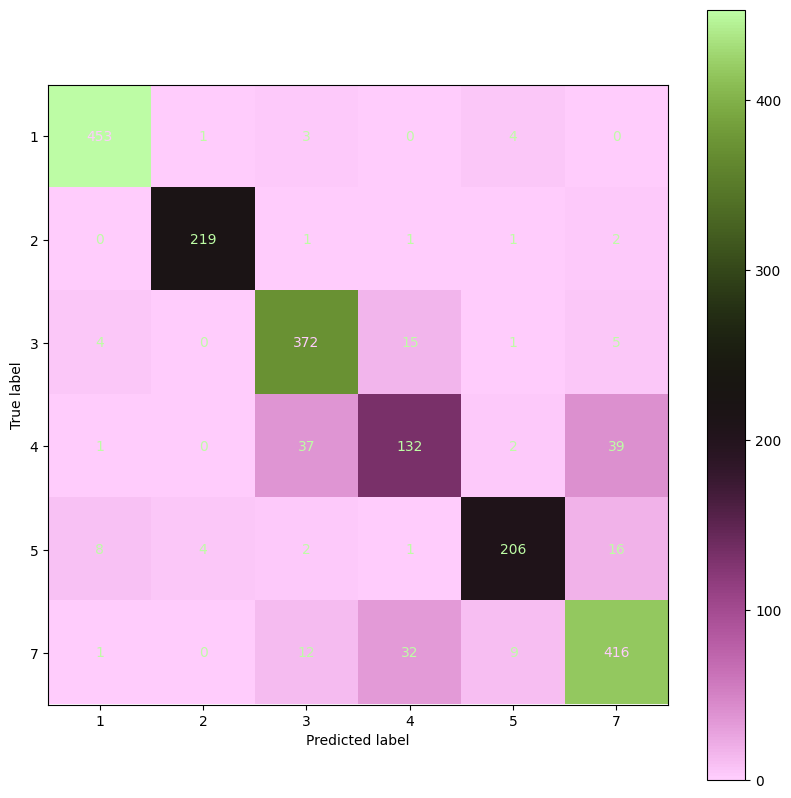

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap='vanimo')

#Conclusion

This Bagging classifier is doing well. With a precision at 91% and both recall and F1 being 90%, this model is accurately and consistently predicing land types.

#Problem 3

#Aquire Data

In [66]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/banknote_authentication.csv')

#Splitting Data into Train/Test

In [67]:
df.head()

,variance,skewness,curtosis,entropy,forgery
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [68]:
X = df.drop(columns=['forgery'])
y = df['forgery']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=35)

In [70]:
X.head()

,variance,skewness,curtosis,entropy
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


#Building the Pipeline

In [71]:
num_attribs = df.columns[0:-1]

In [72]:
print(num_attribs)

Index(['variance', 'skewness', 'curtosis', 'entropy'], dtype='object')


In [73]:
col_transform = ColumnTransformer(transformers=[
                               ('num',MinMaxScaler(), num_attribs)],
                               remainder='passthrough')

In [74]:
random_forest_forgery = Pipeline([
                           ('transform', col_transform),
                           ('rf',RandomForestClassifier(n_estimators=1000, max_samples=100, bootstrap=True))
                     ])

#Executing the Model

In [75]:
random_forest_forgery.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['variance', 'skewness', 'curtosis', 'entropy'], dtype='object'))])),
                ('rf',
                 RandomForestClassifier(max_samples=100, n_estimators=1000))])

#Evaluating the Model

In [76]:
y_pred = random_forest_forgery.predict(X_test)

In [77]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       166
           1       0.96      0.97      0.97       109

    accuracy                           0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275



In [78]:
classes = random_forest_forgery.named_steps.rf.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)


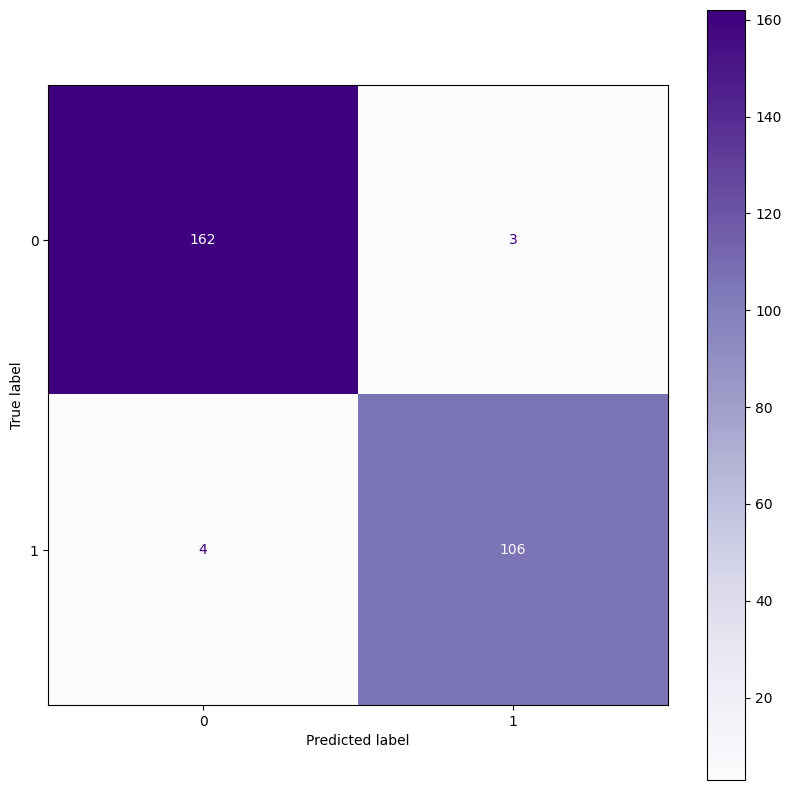

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap='Purples')

#Conclusion

This Random Forest model is performing wonderfully. With an average precision,recall, and f-1 score all sitting above 97%. This model is great for predicting wether or not a banknote is a forgery.